In [114]:
# Importation of useful libraries
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans

from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [3]:
np.random.seed(seed=11)

In [4]:
# This databse contains only posts which had a score of 8 or higher 
df = pd.read_csv("QueryResults_Score8.csv")

In [5]:
df.head(5)

,Id,Title,Tags,Body
0,4,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...,<p>I want to use a track-bar to change a form'...
1,6,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>,<p>I have an absolutely positioned <code>div</...
2,7,NaN,NaN,<p>An explicit cast to double like this isn't ...
3,9,How do I calculate someone's age in C#?,<c#><.net><datetime>,<p>Given a <code>DateTime</code> representing ...
4,11,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,<p>Given a specific <code>DateTime</code> valu...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
Id       50000 non-null int64
Title    16935 non-null object
Tags     16936 non-null object
Body     50000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [7]:
df.drop(columns='Id', inplace=True)

Text(0.5,1,'Ratio of missing values per columns')

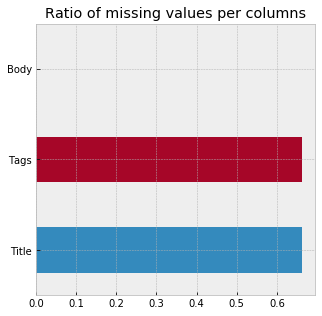

In [8]:
plt.figure(figsize=(5, 5))
df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [9]:
print('Dupplicate entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Dupplicate entries: 4


# 1. Cleaning text

## 1.1 Tags

In this part we only want to take the list of keywords from the tags column, we'll redo the cleaning afterwards to take into account the one did to the body column.

In [19]:
labeled_df = df.dropna(subset=["Tags"])

In [20]:
labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: str(x))

In [21]:
labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: x.replace('<', ''))

In [22]:
labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: x.replace('>', ' '))

In [23]:
labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: x.split())

In [25]:
labeled_df['Tags']

0        [c#, floating-point, type-conversion, double, ...
1                   [html, css, css3, internet-explorer-7]
3                                     [c#, .net, datetime]
4        [c#, datetime, time, datediff, relative-time-s...
6        [javascript, html, browser, timezone, timezone...
7                                             [.net, math]
8                       [c#, linq, web-services, .net-3.5]
9             [mysql, database, binary-data, data-storage]
11       [performance, algorithm, language-agnostic, un...
14                             [mysql, database, triggers]
15                       [c++, c, sockets, mainframe, zos]
22                          [arrays, actionscript-3, flex]
23                     [sql, sql-server, datatable, rdbms]
24                               [c#, .net, vb.net, timer]
25                      [php, plugins, architecture, hook]
28           [html, form-submit, html-form, submit-button]
35                                    [c#, linq, .net-3.

In [26]:
all_tags = [item for sublist in labeled_df['Tags'].values for item in sublist]

In [27]:
len(all_tags)

50481

In [28]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

5371

## 1.2 Body

In [10]:
# Converting html to text in the body

df['Body'] = df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [11]:
# We keep df unchanged from here for later use

df_cleaned = df.copy(deep=True)

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [13]:
df_cleaned['Body'] = df_cleaned['Body'].apply(lambda x: clean_text(x)) 

In [14]:
token=ToktokTokenizer()

In [15]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [17]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [18]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in unique_tags:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(w.translate(remove_punctuation))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [29]:
df_cleaned['Body'] = df_cleaned['Body'].apply(lambda x: clean_punct(x)) 

In [30]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [31]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [32]:
df_cleaned['Body'] = df_cleaned['Body'].apply(lambda x: lemitizeWords(x)) 

In [33]:
df_cleaned['Body'] = df_cleaned['Body'].apply(lambda x: stopWordsRemove(x)) 

## 1.3 Title

In [34]:
train_df = df_cleaned.dropna(subset=["Tags"])

In [35]:
train_df['Title'] = train_df['Title'].apply(lambda x: str(x)) 

In [36]:
train_df['Title'] = train_df['Title'].apply(lambda x: clean_text(x)) 

In [37]:
train_df['Title'] = train_df['Title'].apply(lambda x: clean_punct(x)) 

In [38]:
train_df['Title'] = train_df['Title'].apply(lambda x: lemitizeWords(x)) 

In [39]:
train_df['Title'] = train_df['Title'].apply(lambda x: stopWordsRemove(x)) 

## 1.4 Tags again

In [40]:
train_df['Tags'] = train_df['Tags'].apply(lambda x: str(x))

In [41]:
train_df['Tags'] = train_df['Tags'].apply(lambda x: x.replace('<', ''))

In [42]:
train_df['Tags'] = train_df['Tags'].apply(lambda x: x.replace('>', ' '))

In [43]:
train_df['Tags'] = train_df['Tags'].apply(lambda x: x.split())

# 2. Exploratory analysis with Latent Dirichlet Allocation

In [48]:
no_topics = 20

In [44]:
text = df_cleaned['Body']

In [45]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [46]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [49]:
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [50]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

Topic 0:
var date new key use try foreach linq filename consolewriteline
Topic 1:
server use url request page user send web log asp.net
Topic 2:
svn git file branch repository commit change copy merge subversion
Topic 3:
thread memory exception process use catch call lock throw exceptions
Topic 4:
image div width color html css element height style tag
Topic 5:
foo bar item dim items list warn collection print string
Topic 6:
perl eclipse plugin obj debug install menu year equivalent built-in
Topic 7:
xml mode document service parse extension editor schema believe web
Topic 8:
124 match regex regular expression expressions end amp boost def
Topic 9:
class object public method methods interface property instance parent private
Topic 10:
use code would one program language like time make need
Topic 11:
int return public string function class static void use type
Topic 12:
visual studio address 2008 00 c++ gcc ip port 2005
Topic 13:
test use code project would work tool good like get
Topi

# 3. Supervised Learning

## 3.1 Preprocessing

In [164]:
flat_list = [item for sublist in train_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

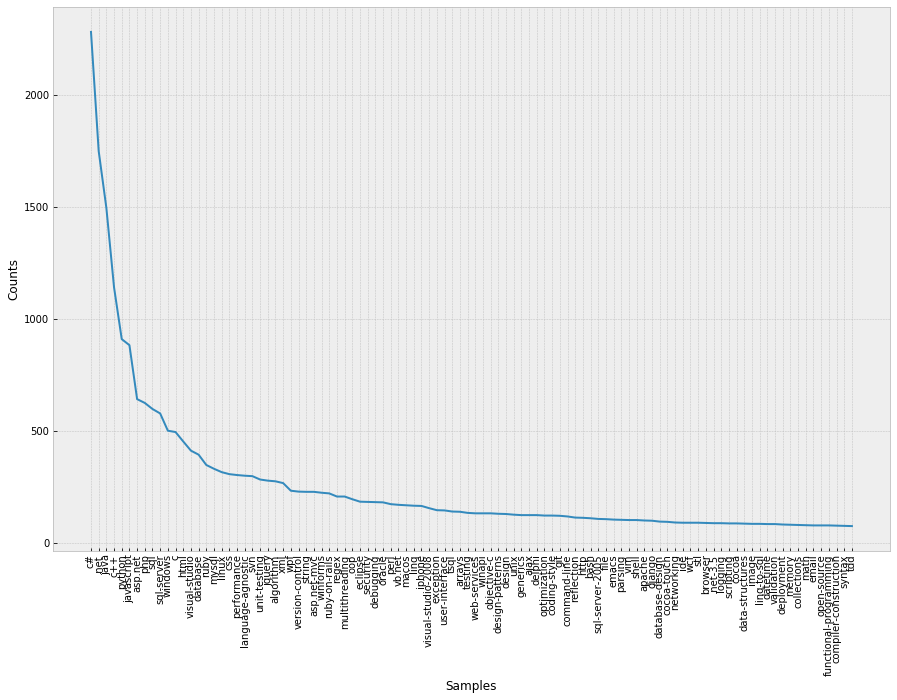

In [123]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [229]:
frequencies_words[99]

('tdd', 75)

In [178]:
# 16936 represents here the total number of tagged posts

print(frequencies_words[0][1]/16936*100, frequencies_words[99][1]/16936*100)

13.474256022673595 0.44284364666981574


In [54]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [55]:
train_df['Tags'] = train_df['Tags'].apply(lambda x: most_common(x))

In [56]:
train_df['Tags'] = train_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [58]:
train_df.shape

(16936, 3)

In [59]:
train_df.dropna(subset=['Tags'], inplace=True)

In [60]:
train_df.shape

(14973, 3)

We are here loosing 2000 rows but the results will be far better with only 100 tags. 

In [61]:
X1 = train_df['Body']
X2 = train_df['Title']
y = train_df['Tags']

In [62]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [63]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [64]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [65]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

## 3.2 OnevsRest

In [195]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

In [116]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 2.7349153350822797
Hamming loss: 0.0328347245409015
---
Clf:  SGDClassifier
Jacard score: 50.5937673900946
Hamming loss: 0.0102771285475793
---
Clf:  LogisticRegression
Jacard score: 42.454090150250416
Hamming loss: 0.01127212020033389
---
Clf:  MultinomialNB
Jacard score: 32.92097941012799
Hamming loss: 0.01325542570951586
---
Clf:  LinearSVC
Jacard score: 50.31496939343351
Hamming loss: 0.011055091819699499
---
Clf:  Perceptron
Jacard score: 43.87031295545486
Hamming loss: 0.016617696160267113
---
Clf:  PassiveAggressiveClassifier
Jacard score: 48.47715890119897
Hamming loss: 0.013435726210350584
---


## 3.4 Neural network

In [121]:
mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)

y_pred = mlpc.predict(X_test)

print_score(y_pred, mlpc)

Clf:  MLPClassifier
Jacard score: 48.04897050639955
Hamming loss: 0.012824707846410684
---


## 3.5 Random Forest

In [122]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print_score(y_pred, rfc)

Clf:  RandomForestClassifier
Jacard score: 39.060100166944906
Hamming loss: 0.012186978297161937
---


## 3.6 GridSearch CV on hyperparemeters 

In [71]:
param_grid = { 
    'estimator__loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'estimator__penalty' : ['l1', 'l2', 'elasticnet'],
    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'estimator__max_iter': [1, 5, 10]
}

In [72]:
sgd = OneVsRestClassifier(SGDClassifier())
CV_rgd = model_selection.GridSearchCV(estimator=sgd, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_rgd.fit(X_train, y_train)

Fitting 5 folds for each of 315 candidates, totalling 1575 fits
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1, score=51.00027824151363, total=   0.8s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1, score=50.50222593210907, total=   0.7s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1, score=51.33903728436282, total=   0.7s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1, score=52.40779401530967, total=   0.7s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1, score=50.56297842727906, total=   0.8s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2, score=47.76224262659989, total=   0.5s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.7s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2, score=47.37896494156927, total=   0.7s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.6s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2, score=47.83319421257652, total=   0.6s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.2s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2, score=47.98816979819067, total=   0.5s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.9s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2, score=47.198329853862205, total=   0.6s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=49.706455203116306, total=   0.8s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=48.48497495826376, total=   0.8s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=48.92111853088481, total=   0.8s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=el

[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=50.350730688935286, total=   4.1s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=49.399443284620745, total=   4.1s
[CV] estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l1, score=48.64565943238731, total=   0.9s
[CV] estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l1, score=47.28158041179745, total=   0.8s
[CV] estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.0001

[CV]  estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1, score=48.67084203201113, total=   4.0s
[CV] estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1, score=46.3688239387613, total=   4.0s
[CV] estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l2, score=40.43823038397329, total=   3.0s
[CV] estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l2, score=40.08416805787423, total=   3.0s
[CV] estimator__alpha=0.0001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.0001, estimator__loss=log, estim

[CV]  estimator__alpha=0.0001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=46.263613959774226, total=   1.1s
[CV] estimator__alpha=0.0001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.0001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=45.796466332776845, total=   1.1s
[CV] estimator__alpha=0.0001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.0001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=45.89979123173277, total=   1.1s
[CV] estimator__alpha=0.0001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.0001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=45.21920668058455, total=   1.1s
[CV] estimator__alpha=0.0001, estimator__loss=modified_huber, estimator__max_iter=

[CV]  estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l2, score=32.76560113512097, total=   0.5s
[CV] estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l2, score=29.899132994122557, total=   0.5s
[CV] estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=33.00093560214595, total=   0.7s
[CV] estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=30.3889162914622, total=   0.7s
[CV] estimator__alpha=0.0001, estimator__loss=squared_hinge

[CV]  estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=39.86753716511646, total=   4.0s
[CV] estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=40.819222513713335, total=   4.0s
[CV] estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=40.28559503935129, total=   3.9s
[CV] estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=40.4686350531862, total=   4.0s
[CV] estimator__alpha=0.0001

[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=elasticnet, score=45.44000397653842, total=   2.1s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=elasticnet, score=43.9509394572025, total=   2.0s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=45.37208177650582, total=   2.6s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=46.09418475236506, total=   2.6s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__max_iter=10, est

[CV]  estimator__alpha=0.001, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1, score=39.534641068447414, total=   1.4s
[CV] estimator__alpha=0.001, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1, score=39.63272120200334, total=   1.4s
[CV] estimator__alpha=0.001, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1, score=40.24008350730689, total=   1.4s
[CV] estimator__alpha=0.001, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1, score=37.71537926235212, total=   1.4s
[CV] estimator__alpha=0.001, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.001, estimator__loss=hinge, es

[CV]  estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2, score=15.91541457985531, total=   0.6s
[CV] estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2, score=17.486783528102393, total=   0.6s
[CV] estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2, score=16.560239287701727, total=   0.6s
[CV] estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2, score=16.144745998608208, total=   0.6s
[CV] estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=0.001, estimator__loss=log, estimator__max_ite

[CV]  estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=elasticnet, score=15.143294379521425, total=   4.6s
[CV] estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=elasticnet, score=16.355036171396772, total=   4.6s
[CV] estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=elasticnet, score=16.122008903728435, total=   4.5s
[CV] estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=elasticnet, score=15.624217118997914, total=   4.5s
[CV] estimator__alpha=0.001, estimator__loss=log, estimator__max_iter=10, estimator__penalty=elasticn

[CV]  estimator__alpha=0.001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=elasticnet, score=44.4497774067891, total=   2.1s
[CV] estimator__alpha=0.001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=elasticnet, score=44.58037578288099, total=   2.6s
[CV] estimator__alpha=0.001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.001, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=elasticnet, score=43.194154488517746, total=   2.4s
[CV] estimator__alpha=0.001, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l1, score=45.02991096271563, total=   3.0s
[CV] estimator__alpha=0.001, estimator__loss=modi

[CV]  estimator__alpha=0.001, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=42.66318719554628, total=   0.7s
[CV] estimator__alpha=0.001, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l1, score=41.40467246998966, total=   1.9s
[CV] estimator__alpha=0.001, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l1, score=40.953821845933696, total=   1.9s
[CV] estimator__alpha=0.001, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l1, score=42.025896335161775, total=   1.9s
[CV] estimator__alpha=0.001, estimator__loss=squared_hinge, estimator__max_iter=5, estim

[CV]  estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1, score=22.125516734239604, total=   0.6s
[CV] estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1, score=34.12214802448525, total=   0.6s
[CV] estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1, score=36.437021572720944, total=   0.6s
[CV] estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1, score=34.61447459986082, total=   0.6s
[CV] estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimato

[CV]  estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=35.54140570633264, total=   2.3s
[CV] estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l2, score=39.700722204895825, total=   1.8s
[CV] estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l2, score=39.02304104724806, total=   1.8s
[CV] estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l2, score=39.593505409448646, total=   1.8s
[CV] estimator__alpha=0.001, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l2 
[CV]  

[CV]  estimator__alpha=0.01, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l2, score=2.025052192066806, total=   1.1s
[CV] estimator__alpha=0.01, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.01, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l2, score=2.2129436325678493, total=   1.1s
[CV] estimator__alpha=0.01, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.01, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=elasticnet, score=2.0798553144129106, total=   1.4s
[CV] estimator__alpha=0.01, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.01, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=elasticnet, score=2.194629938786867, total=   1.4s
[CV] estimator__alpha=0.01, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha

[CV]  estimator__alpha=0.01, estimator__loss=log, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.08350730688935282, total=   0.8s
[CV] estimator__alpha=0.01, estimator__loss=log, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.01, estimator__loss=log, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.08350730688935282, total=   0.8s
[CV] estimator__alpha=0.01, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=0.01, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   2.2s
[CV] estimator__alpha=0.01, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=0.01, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1, score=0.08347245409015025, total=   2.2s
[CV] estimator__alpha=0.01, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=0.01, estimator__loss=log, estimator__max

[CV]  estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1, score=19.8169798190675, total=   0.7s
[CV] estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1, score=19.065414057063325, total=   0.7s
[CV] estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l2, score=18.256121313299943, total=   0.5s
[CV] estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l2, score=18.82929883138564, total=   0.5s
[CV] estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=1, estimator__pen

[CV]  estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2, score=17.40400667779633, total=   2.2s
[CV] estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2, score=18.380634390651085, total=   2.2s
[CV] estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2, score=17.561908736783526, total=   2.2s
[CV] estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2, score=17.55045233124565, total=   2.2s
[CV] estimator__alpha=0.01, estimator__loss=modified_huber, estimator__max_iter=10, estim

[CV]  estimator__alpha=0.01, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l2, score=17.728853644963827, total=   1.3s
[CV] estimator__alpha=0.01, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.01, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l2, score=17.592205984690327, total=   1.3s
[CV] estimator__alpha=0.01, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.01, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=l2, score=17.816283924843425, total=   1.3s
[CV] estimator__alpha=0.01, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.01, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet, score=15.800639955481358, total=   2.0s
[CV] estimator__alpha=0.01, estimator__loss=squared_hinge, estimator__max_iter=5, est

[CV]  estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=elasticnet, score=24.38578185865331, total=   0.6s
[CV] estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=elasticnet, score=22.966750139120755, total=   0.6s
[CV] estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=elasticnet, score=23.539232053422367, total=   0.6s
[CV] estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=elasticnet, score=28.330549756437023, total=   0.6s
[CV] estimator__alpha=0.01, estimator__loss=perceptron, estimator__

[CV]  estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=elasticnet, score=17.559498956158663, total=   2.4s
[CV] estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.01, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=elasticnet, score=22.295755045233125, total=   2.4s
[CV] estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1, score=0.0, total=   0.7s
[CV] estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1, score=0.0, total=   0.7s
[CV] estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=hinge, es

[CV]  estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.0s
[CV] estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.1s
[CV] estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.1s
[CV] estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.1s
[CV] estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.1, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.

[CV]  estimator__alpha=0.1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=elasticnet, score=0.0, total=   2.4s
[CV] estimator__alpha=0.1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=elasticnet, score=0.0, total=   2.4s
[CV] estimator__alpha=0.1, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1, score=0.0, total=   3.9s
[CV] estimator__alpha=0.1, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1, score=0.0, total=   4.0s
[CV] estimator__alpha=0.1, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1, score=0.0, total=  

[CV]  estimator__alpha=0.1, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   1.8s
[CV] estimator__alpha=0.1, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.1, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=0.041736227045075125, total=   1.3s
[CV] estimator__alpha=0.1, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.1, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=0.08347245409015025, total=   1.3s
[CV] estimator__alpha=0.1, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=0.1, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=0.041736227045075125, total=   1.3s
[CV] estimator__alpha=0.1, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  

[CV]  estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l2, score=0.020876826722338204, total=   0.6s
[CV] estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l2, score=0.020876826722338204, total=   0.6s
[CV] estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.0, total=   0.7s
[CV] estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.0, total=   0.7s
[CV] estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=el

[CV]  estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=0.0, total=   3.7s
[CV] estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=0.0, total=   3.7s
[CV] estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=0.0, total=   3.7s
[CV] estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1, score=2.858931552587646, total=   0.6s
[CV] estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimato

[CV]  estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=7.745548135781857, total=   2.3s
[CV] estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=0.0, total=   2.3s
[CV] estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=0.0, total=   2.3s
[CV] estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=7.244954766875435, total=   2.3s
[CV] estimator__alpha=0.1, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=0.1, estimator__loss=perceptr

[CV]  estimator__alpha=1, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l2, score=0.0, total=   1.3s
[CV] estimator__alpha=1, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=1, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l2, score=0.0, total=   1.3s
[CV] estimator__alpha=1, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=1, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l2, score=0.0, total=   1.3s
[CV] estimator__alpha=1, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=1, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=elasticnet, score=0.0, total=   2.0s
[CV] estimator__alpha=1, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=1, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=elasticnet, score=0.0, total=

[CV]  estimator__alpha=1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   2.2s
[CV] estimator__alpha=1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   2.2s
[CV] estimator__alpha=1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   2.2s
[CV] estimator__alpha=1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   2.2s
[CV] estimator__alpha=1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=1, estimator__loss=log, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   2.1s
[CV] estimator__alpha=1, estimator__loss=l

[CV]  estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l2, score=0.0, total=   0.6s
[CV] estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l2, score=0.0, total=   0.6s
[CV] estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.0, total=   0.7s
[CV] estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.0, total=   0.7s
[CV] estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=1, estima

[CV]  estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=elasticnet, score=0.0, total=   3.7s
[CV] estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=1, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=elasticnet, score=0.0, total=   3.7s
[CV] estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l1, score=0.0, total=   0.7s
[CV] estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l1, score=0.0, total=   0.7s
[CV] estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=1, estimator__loss=squared_

[CV]  estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=l1, score=0.0, total=   3.2s
[CV] estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=l1, score=0.0, total=   3.2s
[CV] estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.3s
[CV] estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.3s
[CV] estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=1, estimator__loss=squared_hinge, estimator__max_

[CV]  estimator__alpha=1, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l2, score=12.522318321900784, total=   1.1s
[CV] estimator__alpha=1, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=1, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l2, score=14.739039665970772, total=   1.1s
[CV] estimator__alpha=1, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=1, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=elasticnet, score=5.984974958263773, total=   1.4s
[CV] estimator__alpha=1, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=1, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=elasticnet, score=0.0, total=   1.4s
[CV] estimator__alpha=1, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alp

[CV]  estimator__alpha=10, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.0, total=   0.7s
[CV] estimator__alpha=10, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   1.8s
[CV] estimator__alpha=10, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   1.8s
[CV] estimator__alpha=10, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   1.8s
[CV] estimator__alpha=10, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=hinge, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   1.8s
[CV] es

[CV]  estimator__alpha=10, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2, score=0.1808569838619922, total=   0.6s
[CV] estimator__alpha=10, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=10, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2, score=0.0, total=   0.6s
[CV] estimator__alpha=10, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=10, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l2, score=0.0, total=   0.6s
[CV] estimator__alpha=10, estimator__loss=log, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=10, estimator__loss=log, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.0, total=   0.8s
[CV] estimator__alpha=10, estimator__loss=log, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=10, estimator__loss=log, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.0, 

[CV]  estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1, score=0.0, total=   0.7s
[CV] estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1, score=0.0, total=   0.7s
[CV] estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1, score=0.0, total=   0.7s
[CV] estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1, score=0.0, total=   0.7s
[CV] estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=modified_huber, estim

[CV]  estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.3s
[CV] estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.3s
[CV] estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.3s
[CV] estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2, score=0.0, total=   2.3s
[CV] estimator__alpha=10, estimator__loss=modified_huber, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=10, estimator__loss=modified_hube

[CV]  estimator__alpha=10, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet, score=0.0, total=   2.0s
[CV] estimator__alpha=10, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=10, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet, score=0.0, total=   2.0s
[CV] estimator__alpha=10, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=10, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet, score=0.0, total=   2.0s
[CV] estimator__alpha=10, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  estimator__alpha=10, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet, score=0.0, total=   2.0s
[CV] estimator__alpha=10, estimator__loss=squared_hinge, estimator__max_iter=5, estimator__penalty=elasticnet 
[CV]  es

[CV]  estimator__alpha=10, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   1.3s
[CV] estimator__alpha=10, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   1.3s
[CV] estimator__alpha=10, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   1.4s
[CV] estimator__alpha=10, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l1, score=0.0, total=   1.3s
[CV] estimator__alpha=10, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty=l1 
[CV]  estimator__alpha=10, estimator__loss=perceptron, estimator__max_iter=5, estimator__penalty

[CV]  estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2, score=7.234279354479687, total=   0.6s
[CV] estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2, score=5.460489705063995, total=   0.6s
[CV] estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2, score=4.514468558708959, total=   0.6s
[CV] estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2, score=1.457103091758624, total=   0.6s
[CV] estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=1, estimator__penalty=l2 
[CV]  estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=1

[CV]  estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=0.8569838619922091, total=   3.7s
[CV] estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=3.919429207409174, total=   3.7s
[CV] estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=4.004573019186798, total=   3.7s
[CV] estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=100, estimator__loss=hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=4.2537031514067, total=   3.7s
[CV] estimator__alpha=100, estimator__loss=log, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estima

[CV]  estimator__alpha=100, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1, score=0.5634390651085142, total=   3.9s
[CV] estimator__alpha=100, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=100, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1, score=3.699572522119495, total=   3.9s
[CV] estimator__alpha=100, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=100, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l1, score=0.43841336116910223, total=   3.9s
[CV] estimator__alpha=100, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=100, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l2, score=4.506816917084029, total=   3.0s
[CV] estimator__alpha=100, estimator__loss=log, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=100, estimator__loss=log, estimator__max_iter=10, esti

[CV]  estimator__alpha=100, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=0.3610183639398998, total=   1.4s
[CV] estimator__alpha=100, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=100, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=0.8131608235948803, total=   1.4s
[CV] estimator__alpha=100, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=100, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=5.6471816283924845, total=   1.4s
[CV] estimator__alpha=100, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2 
[CV]  estimator__alpha=100, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=l2, score=6.336812804453723, total=   1.3s
[CV] estimator__alpha=100, estimator__loss=modified_huber, estimator__max_iter=5, estimator__penalty=e

[CV]  estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=l2, score=1.3613182224873248, total=   0.6s
[CV] estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.13912075681691707, total=   0.7s
[CV] estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=1.6833611574846963, total=   0.7s
[CV] estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet 
[CV]  estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=1, estimator__penalty=elasticnet, score=0.0, total=   0.7s
[CV] estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_i

[CV]  estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=0.9971977104698307, total=   3.7s
[CV] estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=0.8997912317327765, total=   3.8s
[CV] estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet 
[CV]  estimator__alpha=100, estimator__loss=squared_hinge, estimator__max_iter=10, estimator__penalty=elasticnet, score=0.6784968684759917, total=   3.7s
[CV] estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1 
[CV]  estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=1, estimator__penalty=l1, score=1.2666944908180302, total=   0.6s
[CV] estimator__alpha=100, estimator__loss=perceptron, estimator__max

[CV]  estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=1.6096271563717304, total=   2.3s
[CV] estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=7.589037284362826, total=   2.3s
[CV] estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=4.069092355104882, total=   2.4s
[CV] estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1 
[CV]  estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l1, score=0.939457202505219, total=   2.3s
[CV] estimator__alpha=100, estimator__loss=perceptron, estimator__max_iter=10, estimator__penalty=l2 
[CV]  estimator__alpha=

[Parallel(n_jobs=1)]: Done 1575 out of 1575 | elapsed: 49.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'estimator__penalty': ['l1', 'l2', 'elasticnet'], 'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'estimator__max_iter': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(avg_jacard), verbose=10)

In [73]:
CV_rgd.best_params_

{'estimator__alpha': 0.0001,
 'estimator__loss': 'hinge',
 'estimator__max_iter': 1,
 'estimator__penalty': 'l1'}

In [112]:
cv_results = pd.DataFrame(CV_rgd.cv_results_)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_estimator__alpha,param_estimator__loss,param_estimator__max_iter,param_estimator__penalty,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.705683,0.021999,51.162409,58.600437,0.0001,hinge,1,l1,"{'estimator__alpha': 0.0001, 'estimator__loss'...",1,...,51.339037,58.329507,52.407794,59.221190,50.562978,58.822916,0.026653,0.002123,0.693286,0.379074
1,0.572805,0.022972,47.632187,63.238170,0.0001,hinge,1,l2,"{'estimator__alpha': 0.0001, 'estimator__loss'...",11,...,47.833194,63.470918,47.988170,62.571394,47.198330,63.357160,0.075381,0.003618,0.295411,0.435190
2,0.871737,0.021788,49.109339,61.419193,0.0001,hinge,1,elasticnet,"{'estimator__alpha': 0.0001, 'estimator__loss'...",8,...,48.921119,60.882732,49.891441,61.665101,48.542797,61.475704,0.216278,0.001692,0.585552,0.312820
3,2.015874,0.026360,51.063338,57.706068,0.0001,hinge,5,l1,"{'estimator__alpha': 0.0001, 'estimator__loss'...",2,...,50.664302,57.510958,51.077244,58.024453,50.917884,57.608960,0.320770,0.011246,0.421376,0.211516
4,1.370947,0.020520,49.289809,71.886029,0.0001,hinge,5,l2,"{'estimator__alpha': 0.0001, 'estimator__loss'...",7,...,49.973567,72.250922,50.352122,72.038158,48.495477,71.629796,0.168719,0.000401,0.742567,0.287908
5,2.277284,0.020954,49.434936,65.218270,0.0001,hinge,5,elasticnet,"{'estimator__alpha': 0.0001, 'estimator__loss'...",5,...,49.762104,65.152195,50.422408,65.443494,48.835769,65.565759,0.013715,0.000618,0.601157,0.259754
6,2.815293,0.021891,50.791868,56.255986,0.0001,hinge,10,l1,"{'estimator__alpha': 0.0001, 'estimator__loss'...",3,...,50.641347,56.205907,51.682672,56.312567,50.130132,56.058646,0.034946,0.001265,0.585435,0.115464
7,1.833278,0.022201,49.333918,73.203021,0.0001,hinge,10,l2,"{'estimator__alpha': 0.0001, 'estimator__loss'...",6,...,49.715498,72.987198,49.958942,73.197155,48.796799,73.422902,0.034504,0.000917,0.434901,0.183618
8,4.105886,0.020905,49.815634,65.935148,0.0001,hinge,10,elasticnet,"{'estimator__alpha': 0.0001, 'estimator__loss'...",4,...,50.005565,65.618347,50.350731,66.036906,49.399443,66.045428,0.050882,0.000406,0.345177,0.163852
9,0.765544,0.020524,48.082596,52.833494,0.0001,log,1,l1,"{'estimator__alpha': 0.0001, 'estimator__loss'...",10,...,48.200473,52.869095,49.339596,52.860795,46.945720,52.772444,0.035058,0.000316,0.876874,0.069060


In [113]:
cv_results[cv_results['params']==CV_rgd.best_params_][['mean_test_score', 'std_test_score']]

,mean_test_score,std_test_score
0,51.162409,0.693286


In [118]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(avg_jacard,greater_is_better=True))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [76]:
title = "Learning Curves (SGD)"

In [81]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

<module 'matplotlib.pyplot' from '/Users/miljanstojiljkovic/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

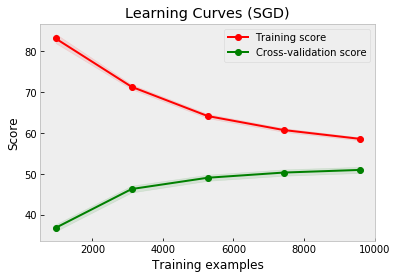

In [124]:
plot_learning_curve(CV_rgd.best_estimator_, title, X_train, y_train, cv=cv)

## 3.7 Confusion matrix

In [92]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

.net
[[2612   28]
 [ 240  115]]

.net-3.5
[[2974    0]
 [  21    0]]

ajax
[[2969    0]
 [  24    2]]

algorithm
[[2936    6]
 [  32   21]]

apache
[[2968    1]
 [  21    5]]

arrays
[[2965    2]
 [  27    1]]

asp.net
[[2851    4]
 [ 107   33]]

asp.net-mvc
[[2951    0]
 [  20   24]]

bash
[[2975    1]
 [  13    6]]

browser
[[2973    0]
 [  22    0]]

c
[[2885    2]
 [ 101    7]]

c#
[[2486   38]
 [ 254  217]]

c++
[[2747   14]
 [ 111  123]]

cocoa
[[2984    0]
 [  10    1]]

cocoa-touch
[[2983    1]
 [  11    0]]

coding-style
[[2971    0]
 [  24    0]]

collections
[[2980    0]
 [  15    0]]

command-line
[[2965    1]
 [  28    1]]

compiler-construction
[[2981    1]
 [  13    0]]

css
[[2925    5]
 [  30   35]]

data-structures
[[2978    0]
 [  17    0]]

database
[[2911    3]
 [  73    8]]

database-design
[[2969    0]
 [  26    0]]

datetime
[[2976    0]
 [  19    0]]

debugging
[[2957    0]
 [  37    1]]

delphi
[[2974    0]
 [   7   14]]

deployment
[[2980    0]
 [  15    0]]


## 3.8 Extracting feature importance

In [234]:
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [152]:
feature_names = vectorizer_X1.get_feature_names() + vectorizer_X2.get_feature_names()

In [235]:
print_top10(feature_names, CV_rgd.best_estimator_, multilabel_binarizer.classes_)

.net: new whole wpf try framework private dlls assembly .net .net
.net-3.5: page .net return linq query conditional object auto 35 35
ajax: pretty call tcp html row upload json plugin ajax ajax
algorithm: calculate number solve matter efficient random algorithms algorithms algorithm algorithm
apache: primary every redirect web user script modules https apache apache
arrays: remove collection row powershell key object elegant merge array array
asp.net: error happen control page iis listview gridview asp asp.net asp.net
asp.net-mvc: value asp.net bite however redirect input action controller mvc mvc
bash: fix scope different three echo produce one script bash bash
browser: system request web local point information browsers browsers browser browser
c: standard speed int define stdout struct embed gcc cc cc
c#: manage bool get byte new event foreach static c# c#
c++: run pointer const stl cc boost cc std c++ c++
cocoa: input start os code object learn sure way objective-c cocoa
cocoa-touc

## 3.9 Saving the finale model

In [227]:
with open('model.pickle', 'wb') as h:
    pickle.dump([CV_rgd.best_estimator_, vectorizer_X1, vectorizer_X2, unique_tags, multilabel_binarizer], h)

# 4. Unsupervised learning with Word2Vec

The following parts are based on the tutorial from Kaggle "Bag of Words Meets Bags of Popcorn"

## 4.1 Training word2vec model

In [209]:
df_w2v = df.copy(deep=True)

In [210]:
def clean_text2(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return token.tokenize(text)

In [211]:
df_w2v['Body'] = df_w2v['Body'].apply(lambda x: str(x))

In [212]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [213]:
# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( clean_text2(raw_sentence))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [214]:
text = df_w2v['Body']

In [101]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for questions in text:
    sentences += review_to_sentences(questions, tokenizer)

Parsing sentences from training set


In [102]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 200    # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

with open('word2vec2.pickle', 'wb') as g:
    pickle.dump(model, g)

2018-10-16 23:48:25,551 : INFO : collecting all words and their counts
2018-10-16 23:48:25,552 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-10-16 23:48:25,609 : INFO : PROGRESS: at sentence #10000, processed 245532 words, keeping 16719 word types
2018-10-16 23:48:25,668 : INFO : PROGRESS: at sentence #20000, processed 486306 words, keeping 26304 word types
2018-10-16 23:48:25,749 : INFO : PROGRESS: at sentence #30000, processed 735818 words, keeping 35766 word types


Training model...


2018-10-16 23:48:25,820 : INFO : PROGRESS: at sentence #40000, processed 986746 words, keeping 43882 word types
2018-10-16 23:48:25,883 : INFO : PROGRESS: at sentence #50000, processed 1229355 words, keeping 51755 word types
2018-10-16 23:48:25,944 : INFO : PROGRESS: at sentence #60000, processed 1474496 words, keeping 59798 word types
2018-10-16 23:48:26,012 : INFO : PROGRESS: at sentence #70000, processed 1724455 words, keeping 67156 word types
2018-10-16 23:48:26,082 : INFO : PROGRESS: at sentence #80000, processed 1972609 words, keeping 74767 word types
2018-10-16 23:48:26,143 : INFO : PROGRESS: at sentence #90000, processed 2218709 words, keeping 81373 word types
2018-10-16 23:48:26,217 : INFO : PROGRESS: at sentence #100000, processed 2470991 words, keeping 88716 word types
2018-10-16 23:48:26,288 : INFO : PROGRESS: at sentence #110000, processed 2720456 words, keeping 95054 word types
2018-10-16 23:48:26,392 : INFO : PROGRESS: at sentence #120000, processed 2968584 words, keepin

2018-10-16 23:48:54,450 : INFO : EPOCH - 4 : training on 6558177 raw words (4287115 effective words) took 6.4s, 674649 effective words/s
2018-10-16 23:48:55,459 : INFO : EPOCH 5 - PROGRESS: at 16.31% examples, 692721 words/s, in_qsize 7, out_qsize 0
2018-10-16 23:48:56,475 : INFO : EPOCH 5 - PROGRESS: at 34.27% examples, 719166 words/s, in_qsize 8, out_qsize 0
2018-10-16 23:48:57,485 : INFO : EPOCH 5 - PROGRESS: at 50.00% examples, 700846 words/s, in_qsize 7, out_qsize 0
2018-10-16 23:48:58,487 : INFO : EPOCH 5 - PROGRESS: at 62.87% examples, 664328 words/s, in_qsize 7, out_qsize 0
2018-10-16 23:48:59,492 : INFO : EPOCH 5 - PROGRESS: at 81.63% examples, 691703 words/s, in_qsize 7, out_qsize 0
2018-10-16 23:49:00,480 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-10-16 23:49:00,485 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-10-16 23:49:00,494 : INFO : EPOCH 5 - PROGRESS: at 99.90% examples, 709907 words/s, in_qsize 1, out_qsize 1
201

In [103]:
model.most_similar("c#")

[('vb.net', 0.7848778963088989),
 ('vb', 0.7408594489097595),
 ('java', 0.716537594795227),
 ('.net', 0.6848857402801514),
 ('objective-c', 0.6520114541053772),
 ('3.0', 0.6498465538024902),
 ('f#', 0.6490616798400879),
 ('delphi', 0.6125437617301941),
 ('vb6', 0.6109596490859985),
 ('generics', 0.6060250997543335)]

In [104]:
model.most_similar("java")

[('c#', 0.716537594795227),
 ('ee', 0.6860156059265137),
 ('objective-c', 0.6708859205245972),
 ('c/c++', 0.6213827133178711),
 ('jdk', 0.6186753511428833),
 ('sun', 0.6066051125526428),
 ('swing', 0.6008199453353882),
 ('delphi', 0.5990964770317078),
 ('vb.net', 0.5990627408027649),
 ('f#', 0.5922967195510864)]

## 4.2 Applying a kmeans

In [105]:
start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.syn0
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  114.33631706237793 seconds.


In [106]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.wv.index2word, idx ))

In [107]:
# For the first 10 clusters
for cluster in range(0,10):
    #
    # Print the cluster number  
    print("\nCluster %d" % cluster)
    #
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(word_centroid_map.values())):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['published', 'presented', 'discussed', 'pseudo-code']

Cluster 1
['</appender>', '</layout>']

Cluster 2
['installers', 'installations']

Cluster 3
['n-1', 'p[', 'l2', 'out[', 'l1', 'maxsize']

Cluster 4
['yui', 'cross-browser', 'rhino', 'extjs', 'compressor', 'mootools', 'dojo', 'gears', 'uploader']

Cluster 5
['represented', 'calculated', 'aligned', 'expressed', 'computed', 'composed']

Cluster 6
['li', 'footer', '<table>', 'collapse', '<ul', '<select>', 'sortable', 'sticky']

Cluster 7
['dosomething']

Cluster 8
['analysis', 'profiling', 'metrics']

Cluster 9
['diff', '-a', 'mysqldump', '-b', 'netstat', 'sendmail', 'nm', 'psql', 'gitk', 'ulimit']


## 4.3 Vectorize our training data 

In [108]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

In [215]:
labeled_df = df_w2v.dropna(subset=["Tags"])

In [216]:
labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: str(x))

labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: x.replace('<', ''))

labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: x.replace('>', ' '))

labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: x.split())

In [217]:
flat_list = [item for sublist in labeled_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [218]:
labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: most_common(x))

In [219]:
labeled_df['Tags'] = labeled_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [220]:
labeled_df.dropna(subset=['Tags'], inplace=True)

In [221]:
X = labeled_df['Body']
y = labeled_df['Tags']

In [222]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

In [224]:
clean_train_questions = []
for question in X_train:
    clean_train_questions.append(token.tokenize(question))


clean_test_questions = []
for question in X_test:
    clean_test_questions.append(token.tokenize(question))


In [225]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros( (X_train.size, num_clusters), dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for question in clean_train_questions:
    train_centroids[counter] = create_bag_of_centroids( question, word_centroid_map )
    counter += 1

# Repeat for test reviews 
test_centroids = np.zeros(( X_test.size, num_clusters), dtype="float32" )

counter = 0
for question in clean_test_questions:
    test_centroids[counter] = create_bag_of_centroids( question, word_centroid_map )
    counter += 1

In [237]:
X_train[1]

"I have an absolutely positioned div containing several children, one of which is a relatively positioned div. When I use a percentage-based width on the child div, it collapses to '0' width on Internet\xa0Explorer\xa07, but not on Firefox or Safari.\nIf I use pixel width, it works. If the parent is relatively positioned, the percentage width on the child works.\n\nIs there something I'm missing here?\nIs there an easy fix for this besides the pixel-based width on the\nchild?\nIs there an area of the CSS specification that covers this?\n\n"

In [239]:
np.set_printoptions(threshold=np.inf)

In [240]:
train_centroids[1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  3.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

## 4.4 Testing performance

In [226]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(train_centroids, y_train)
    y_pred = clf.predict(test_centroids)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 2.5492222487214145
Hamming loss: 3.275125208681135
---
Clf:  SGDClassifier
Jacard score: 16.386425668562563
Hamming loss: 2.4046744574290484
---
Clf:  LogisticRegression
Jacard score: 17.72589236028301
Hamming loss: 1.8677796327212022
---
Clf:  MultinomialNB
Jacard score: 17.072863957912677
Hamming loss: 4.270116861435726
---
Clf:  LinearSVC
Jacard score: 16.701645599809204
Hamming loss: 2.5953255425709516
---
Clf:  Perceptron
Jacard score: 16.106831491639504
Hamming loss: 2.5155258764607678
---
Clf:  PassiveAggressiveClassifier
Jacard score: 13.924158479250298
Hamming loss: 2.4801335559265443
---


In [197]:
mlpc = MLPClassifier()
mlpc.fit(train_centroids, y_train)

y_pred = mlpc.predict(test_centroids)

print_score(y_pred, mlpc)

Clf:  MLPClassifier
Jacard score: 19.650382913321142
Hamming loss: 2.2721202003338896
---


In [198]:
rfc = RandomForestClassifier()
rfc.fit(train_centroids, y_train)

y_pred = rfc.predict(test_centroids)

print_score(y_pred, rfc)

Clf:  RandomForestClassifier
Jacard score: 3.286032276015581
Hamming loss: 1.701502504173623
---


## 4.5 Trying a pre trained model 

Authors of the model : Efstathiou, V., Chatzilenas, C., Spinellis, D., 2018. "Word Embeddings for the Software Engineering Domain"

In [199]:
from gensim.models.keyedvectors import KeyedVectors
word_vect = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

2018-10-18 11:33:46,972 : INFO : loading projection weights from SO_vectors_200.bin
2018-10-18 11:34:16,828 : INFO : loaded (1787145, 200) matrix from SO_vectors_200.bin


In [200]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    #
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    #
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    #
    # Initialize a counter
    counter = 0.
    #
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    #
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
        if counter%1000. == 0.:
            print("Review %d of %d" % (counter, len(reviews)))
       #
       # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       #
       # Increment the counter
        counter = counter + 1.
    return reviewFeatureVecs

In [201]:
print("Creating average feature vecs for train reviews")
clean_train_questions = []
for question in X_train:
    clean_train_questions.append(token.tokenize(question))

trainDataVecs = getAvgFeatureVecs( clean_train_questions, word_vect, 200 )

print("Creating average feature vecs for test reviews")
clean_test_questions = []
for question in X_test:
    clean_test_questions.append(token.tokenize(question))

testDataVecs = getAvgFeatureVecs( clean_test_questions, word_vect, 200 )

Creating average feature vecs for train reviews
Review 0 of 11978
Review 1000 of 11978
Review 2000 of 11978
Review 3000 of 11978
Review 4000 of 11978
Review 5000 of 11978
Review 6000 of 11978
Review 7000 of 11978
Review 8000 of 11978
Review 9000 of 11978
Review 10000 of 11978
Review 11000 of 11978
Creating average feature vecs for test reviews
Review 0 of 2995
Review 1000 of 2995
Review 2000 of 2995


In [202]:
np.isnan(np.min(trainDataVecs))

True

In [203]:
trainDataVecs2 = np.nan_to_num(trainDataVecs)

## 4.4 Testing performance

In [228]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(trainDataVecs2, y_train)
    y_pred = clf.predict(testDataVecs)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 2.9138378779447227
Hamming loss: 3.286143572621035
---
Clf:  SGDClassifier
Jacard score: 15.145269773817352
Hamming loss: 2.536227045075125
---
Clf:  LogisticRegression
Jacard score: 15.254131243016229
Hamming loss: 1.799332220367279
---
Clf:  LinearSVC
Jacard score: 12.750157758944333
Hamming loss: 1.7245409015025044
---
Clf:  Perceptron
Jacard score: 15.857921309449797
Hamming loss: 2.4373956594323873
---
Clf:  PassiveAggressiveClassifier
Jacard score: 17.40036692092603
Hamming loss: 2.9993322203672785
---


In [206]:
mlpc = MLPClassifier()
mlpc.fit(trainDataVecs2, y_train)

y_pred = mlpc.predict(testDataVecs)

print_score(y_pred, mlpc)

Clf:  MLPClassifier
Jacard score: 21.17863105175292
Hamming loss: 1.8450751252086812
---


In [207]:
rfc = RandomForestClassifier()
rfc.fit(trainDataVecs2, y_train)

y_pred = rfc.predict(testDataVecs)

print_score(y_pred, rfc)

Clf:  RandomForestClassifier
Jacard score: 1.2743461324429604
Hamming loss: 1.723205342237062
---
